# Neural/MLForecast

This example notebook demonstrates the compatibility of HierarchicalForecast's reconciliation methods with popular machine-learning libraries, specifically [NeuralForecast](https://github.com/Nixtla/neuralforecast) and [MLForecast](https://github.com/Nixtla/mlforecast).

The notebook utilizes NBEATS and XGBRegressor models to create base forecasts for the TourismLarge Hierarchical Dataset. After that, we use HierarchicalForecast to reconcile the base predictions.

**References**<br>
- [Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2019). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting". url: https://arxiv.org/abs/1905.10437](https://arxiv.org/abs/1905.10437)<br>
- [Tianqi Chen and Carlos Guestrin. “XGBoost: A Scalable Tree Boosting System”. In: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. KDD ’16. San Francisco, California, USA: Association for Computing Machinery, 2016, pp. 785–794. isbn: 9781450342322. doi: 10.1145/2939672.2939785. url: https://doi.org/10.1145/2939672.2939785 (cit. on p. 26).](https://doi.org/10.1145/2939672.2939785)<br>


You can run these experiments using CPU or GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/MLFrameworksExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing packages

In [ ]:
%%capture
!pip install datasetsforecast mlforecast 
!pip install git+https://github.com/Nixtla/neuralforecast.git
!pip install git+https://github.com/Nixtla/hierarchicalforecast.git

In [ ]:
import numpy as np
import pandas as pd

from datasetsforecast.hierarchical import HierarchicalData

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import GMM

from mlforecast import MLForecast
from window_ops.expanding import expanding_mean
from mlforecast.utils import PredictionIntervals
from mlforecast.target_transforms import Differences
import xgboost as xgb

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.utils import HierarchicalPlot
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import scaled_crps

## 2. Load hierarchical dataset

This detailed Australian Tourism Dataset comes from the National Visitor Survey, managed by the Tourism Research Australia, it is composed of 555 monthly series from 1998 to 2016, it is organized geographically, and purpose of travel. The natural geographical hierarchy comprises seven states, divided further in 27 zones and 76 regions. The purpose of travel categories are holiday, visiting friends and relatives (VFR), business and other. The MinT (Wickramasuriya et al., 2019), among other hierarchical forecasting studies has used the dataset it in the past. The dataset can be accessed in the [MinT reconciliation webpage](https://robjhyndman.com/publications/mint/), although other sources are available.

| Geographical Division | Number of series per division | Number of series per purpose | Total |
|          ---          |               ---             |              ---             |  ---  |
|  Australia            |              1                |               4              |   5   |
|  States               |              7                |              28              |  35   |
|  Zones                |             27                |              108             |  135  |
|  Regions              |             76                |              304             |  380  |
|  Total                |            111                |              444             |  555  |


In [ ]:
Y_df, S_df, tags = HierarchicalData.load('./data', 'TourismLarge')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [ ]:
Y_df.head()

,unique_id,ds,y
0,TotalAll,1998-01-01,45151.071280
1,TotalAll,1998-02-01,17294.699551
2,TotalAll,1998-03-01,20725.114184
3,TotalAll,1998-04-01,25388.612353
4,TotalAll,1998-05-01,20330.035211


Visualize the aggregation matrix.

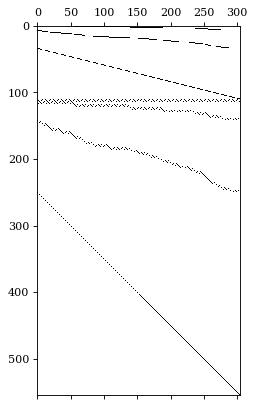

In [ ]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

Split the dataframe in train/test splits.

In [ ]:
def sort_hier_df(Y_df, S_df):
    # sorts unique_id lexicographically
    Y_df.unique_id = Y_df.unique_id.astype('category')
    Y_df.unique_id = Y_df.unique_id.cat.set_categories(S_df.index)
    Y_df = Y_df.sort_values(by=['unique_id', 'ds'])
    return Y_df

Y_df = sort_hier_df(Y_df, S_df)

In [ ]:
horizon = 12
Y_test_df = Y_df.groupby('unique_id').tail(horizon)
Y_train_df = Y_df.drop(Y_test_df.index)

## 3. Fit and Predict Models

HierarchicalForecast is compatible with many different ML models. Here, we show two examples:<br>
1. NBEATS, a MLP-based deep neural architecture.<br> 
2. XGBRegressor, a tree-based architecture.<br>

In [ ]:
level = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in level]
quantiles = np.sort(np.concatenate(qs)/100)

#fit/predict NBEATS from NeuralForecast
nbeats = NBEATS(h=horizon,
              input_size=2*horizon,
              loss=GMM(n_components=10, quantiles=quantiles),
              scaler_type='robust',
              max_steps=2000)
nf = NeuralForecast(models=[nbeats], freq='MS')
nf.fit(df=Y_train_df)
Y_hat_nf = nf.predict()

#fit/predict XGBRegressor from MLForecast
mf = MLForecast(models=[xgb.XGBRegressor()], 
                freq='MS',
                lags=[1,2,12,24],
                date_features=['month'],
                )
mf.fit(Y_train_df, prediction_intervals=PredictionIntervals(n_windows=10, window_size=horizon)) 
Y_hat_mf = mf.predict(horizon, level=level).set_index('unique_id')

INFO:lightning_fabric.utilities.seed:Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
Y_hat_nf

,ds,NBEATS,NBEATS-lo-98.0,NBEATS-lo-96.0,NBEATS-lo-94.0,NBEATS-lo-92.0,NBEATS-lo-90.0,NBEATS-lo-88.0,NBEATS-lo-86.0,NBEATS-lo-84.0,...,NBEATS-hi-80.0,NBEATS-hi-82.0,NBEATS-hi-84.0,NBEATS-hi-86.0,NBEATS-hi-88.0,NBEATS-hi-90.0,NBEATS-hi-92.0,NBEATS-hi-94.0,NBEATS-hi-96.0,NBEATS-hi-98.0
unique_id,,,,,,,,,,,,,,,,,,,,,
TotalAll,2016-01-01,44304.039062,24825.771484,26974.607422,27405.914062,27881.269531,28640.238281,29469.513672,30213.277344,31009.929688,...,51838.828125,52150.523438,52404.886719,52564.652344,52951.238281,53216.839844,53689.351562,54015.074219,54545.882812,55752.621094
TotalAll,2016-02-01,20877.984375,17909.365234,18334.902344,18577.355469,18653.085938,18755.072266,18839.824219,18965.947266,19074.134766,...,22756.220703,22892.509766,23029.402344,23133.941406,23221.666016,23385.628906,23587.021484,23862.343750,24243.560547,24526.462891
TotalAll,2016-03-01,23444.972656,18971.355469,19329.705078,19472.619141,19756.503906,19843.703125,20075.363281,20126.689453,20259.271484,...,26024.242188,26116.677734,26196.498047,26342.339844,26535.798828,26758.476562,26934.582031,27097.130859,27441.996094,27704.375000
TotalAll,2016-04-01,28927.132812,24030.257812,24540.779297,24732.566406,24988.001953,25160.744141,25304.658203,25456.001953,25567.078125,...,31568.966797,31698.855469,31856.851562,32097.916016,32211.320312,32345.988281,32510.902344,32724.638672,33078.031250,33525.035156
TotalAll,2016-05-01,22716.433594,19728.511719,19910.925781,20089.443359,20214.955078,20269.906250,20355.708984,20441.349609,20491.029297,...,24937.335938,25114.396484,25270.279297,25446.765625,25676.287109,26028.427734,26440.011719,27477.541016,28452.419922,29793.591797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GBDOth,2016-08-01,4.731373,-30.691290,-8.694043,-2.576124,-2.196553,-2.069076,-1.913422,-1.854156,-1.767804,...,9.252028,10.948211,12.031944,14.396760,18.523523,43.287716,58.207531,69.754929,81.399673,116.701561
GBDOth,2016-09-01,5.685491,-32.813366,-11.985416,-2.978264,-2.413029,-2.120405,-1.788605,-1.673310,-1.550562,...,12.787840,14.330542,15.563581,16.996040,29.901039,45.086597,60.724380,75.462578,92.432518,125.217796
GBDOth,2016-10-01,4.760162,-51.105358,-27.034277,-8.493114,-2.859874,-2.140030,-1.905673,-1.764797,-1.621011,...,10.930604,11.960605,13.876516,14.839364,18.540100,32.251144,48.573261,65.301460,83.327026,113.249001


In [ ]:
Y_hat_mf

,ds,XGBRegressor,XGBRegressor-lo-98,XGBRegressor-lo-96,XGBRegressor-lo-94,XGBRegressor-lo-92,XGBRegressor-lo-90,XGBRegressor-lo-88,XGBRegressor-lo-86,XGBRegressor-lo-84,...,XGBRegressor-hi-80,XGBRegressor-hi-82,XGBRegressor-hi-84,XGBRegressor-hi-86,XGBRegressor-hi-88,XGBRegressor-hi-90,XGBRegressor-hi-92,XGBRegressor-hi-94,XGBRegressor-hi-96,XGBRegressor-hi-98
unique_id,,,,,,,,,,,,,,,,,,,,,
TotalAll,2016-01-01,43891.531250,39048.053886,39398.911368,39749.768850,40100.626332,40451.483815,40561.804681,40586.219613,40610.634545,...,47123.598090,47148.013022,47172.427955,47196.842887,47221.257819,47331.578685,47682.436168,48033.293650,48384.151132,48735.008614
TotalAll,2016-02-01,20715.656250,18476.756884,18482.492537,18488.228190,18493.963842,18499.699495,18539.212692,18590.789297,18642.365902,...,22685.793388,22737.369993,22788.946598,22840.523203,22892.099808,22931.613005,22937.348658,22943.084310,22948.819963,22954.555616
TotalAll,2016-03-01,23008.896484,17292.312227,17323.859641,17355.407055,17386.954469,17418.501883,17582.396869,17793.558844,18004.720819,...,27590.748200,27801.910175,28013.072150,28224.234125,28435.396100,28599.291085,28630.838500,28662.385914,28693.933328,28725.480742
TotalAll,2016-04-01,27731.050781,22333.047144,22537.510145,22741.973145,22946.436145,23150.899146,23233.881164,23273.477118,23313.073071,...,32069.836584,32109.432538,32149.028491,32188.624445,32228.220398,32311.202417,32515.665417,32720.128417,32924.591418,33129.054418
TotalAll,2016-05-01,24898.529297,21768.004677,21859.564615,21951.124552,22042.684490,22134.244428,22222.835407,22310.366042,22397.896678,...,27224.100644,27311.631280,27399.161916,27486.692551,27574.223187,27662.814166,27754.374104,27845.934041,27937.493979,28029.053917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GBDOth,2016-08-01,8.842277,-2.504086,-1.296329,-0.088571,1.119187,2.326944,2.794274,2.997165,3.200056,...,14.078715,14.281606,14.484497,14.687388,14.890279,15.357609,16.565366,17.773124,18.980882,20.188639
GBDOth,2016-09-01,4.991811,-1.879816,-1.879816,-1.879816,-1.879816,-1.879816,-1.635940,-1.304965,-0.973990,...,10.295662,10.626637,10.957612,11.288587,11.619561,11.863438,11.863438,11.863438,11.863438,11.863438
GBDOth,2016-10-01,8.647715,2.339581,2.339581,2.339581,2.339581,2.339581,2.339581,2.339581,2.339581,...,14.955848,14.955848,14.955848,14.955848,14.955848,14.955848,14.955848,14.955848,14.955848,14.955848


## 4. Reconcile Predictions
With minimal parsing, we can reconcile the raw output predictions with different HierarchicalForecast reconciliation methods.

:::{.callout-warning collapse="false"}
#### Reconciliation Methods Availability

The following reconciliation methods require access to insample predictions:<br>
- `ERM(method='closed'), ERM(method='reg_bu')`<br>
- `TopDown(method='average_proportions'), TopDown(method='proportion_averages')`<br>
- `MiddleOut(top_down_method='average_proportions'), MiddleOut(top_down_method='proportion_averages')`<br>
- `MinTrace(method='wls_var'), MinTrace(method='mint_cov'), MinTrace(method='mint_shrink')`<br>

You can obtain NeuralForecast's insample predictions via the [`NeuralForecast.predict_insample`](https://nixtla.github.io/neuralforecast/core.html#neuralforecast.predict_insample) method.

We are working on making MLForecast's insample predictions available.
:::

In [ ]:
reconcilers = [
    BottomUp(),
    MinTrace('ols')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_nf = hrec.reconcile(Y_hat_df=Y_hat_nf, Y_df = Y_train_df, S=S_df, tags=tags, level=level)
Y_rec_mf = hrec.reconcile(Y_hat_df=Y_hat_mf, Y_df = Y_train_df, S=S_df, tags=tags, level=level)

## 5. Evaluation

To evaluate we use a scaled variation of the CRPS, as proposed by Rangapuram (2021), to measure the accuracy of predicted quantiles `y_hat` compared to the observation `y`.

$$
\mathrm{sCRPS}(\hat{F}_{\tau}, \mathbf{y}_{\tau}) = \frac{2}{N} \sum_{i}
\int^{1}_{0}
\frac{\mathrm{QL}(\hat{F}_{i,\tau}, y_{i,\tau})_{q}}{\sum_{i} | y_{i,\tau} |} dq
$$

In [ ]:
rec_model_names_nf = ['NBEATS/BottomUp', 'NBEATS/MinTrace_method-ols']
rec_model_names_mf = ['XGBRegressor/BottomUp', 'XGBRegressor/MinTrace_method-ols']

n_quantiles = len(quantiles)
n_series = len(S_df)

for name in rec_model_names_nf:
    quantile_columns = [col for col in Y_rec_nf.columns if (name+'-lo') in col or (name+'-hi') in col]
    y_rec  = Y_rec_nf[quantile_columns].values 
    y_test = Y_test_df['y'].values

    y_rec  = y_rec.reshape(n_series, horizon, n_quantiles)
    y_test = y_test.reshape(n_series, horizon)
    scrps  = scaled_crps(y=y_test, y_hat=y_rec, quantiles=quantiles)
    print("{:<40} {:.5f}".format(name+":", scrps))

for name in rec_model_names_mf:
    quantile_columns = [col for col in Y_rec_mf.columns if (name+'-lo') in col or (name+'-hi') in col]
    y_rec  = Y_rec_mf[quantile_columns].values 
    y_test = Y_test_df['y'].values

    y_rec  = y_rec.reshape(n_series, horizon, n_quantiles)
    y_test = y_test.reshape(n_series, horizon)
    scrps  = scaled_crps(y=y_test, y_hat=y_rec, quantiles=quantiles)
    print("{:<40} {:.5f}".format(name+":", scrps))

NBEATS/BottomUp:                         0.12853
NBEATS/MinTrace_method-ols:              0.12945
XGBRegressor/BottomUp:                   0.13202
XGBRegressor/MinTrace_method-ols:        0.13417


## 6. Visualizations

In [ ]:
plot_nf = pd.concat([Y_df.set_index(['unique_id', 'ds']), 
                     Y_rec_nf.set_index('ds', append=True)], axis=1)
plot_nf = plot_nf.reset_index('ds')

plot_mf = pd.concat([Y_df.set_index(['unique_id', 'ds']), 
                     Y_rec_mf.set_index('ds', append=True)], axis=1)
plot_mf = plot_mf.reset_index('ds')

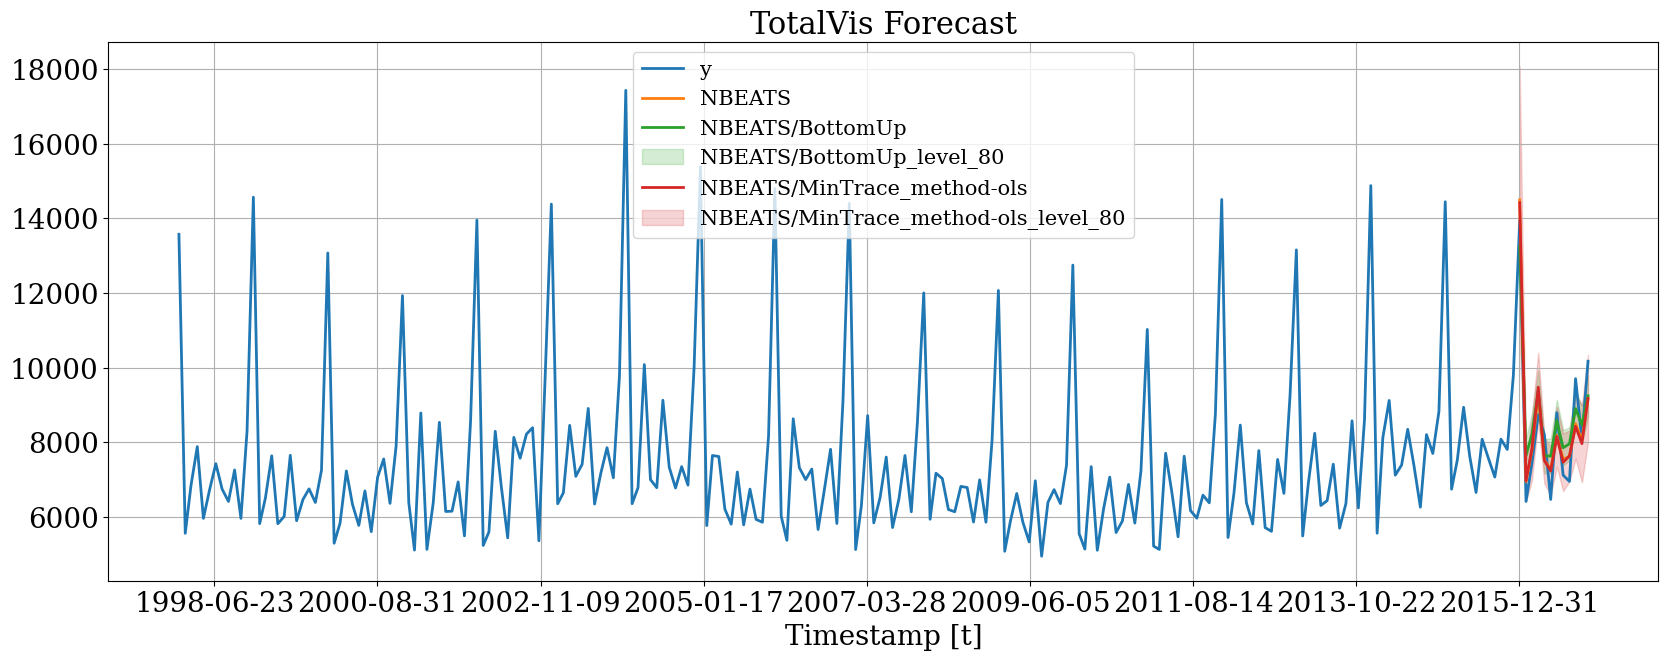

In [ ]:
hplot.plot_series(
    series='TotalVis',
    Y_df=plot_nf, 
    models=['y', 'NBEATS', 'NBEATS/BottomUp', 'NBEATS/MinTrace_method-ols'],
    level=[80]
)

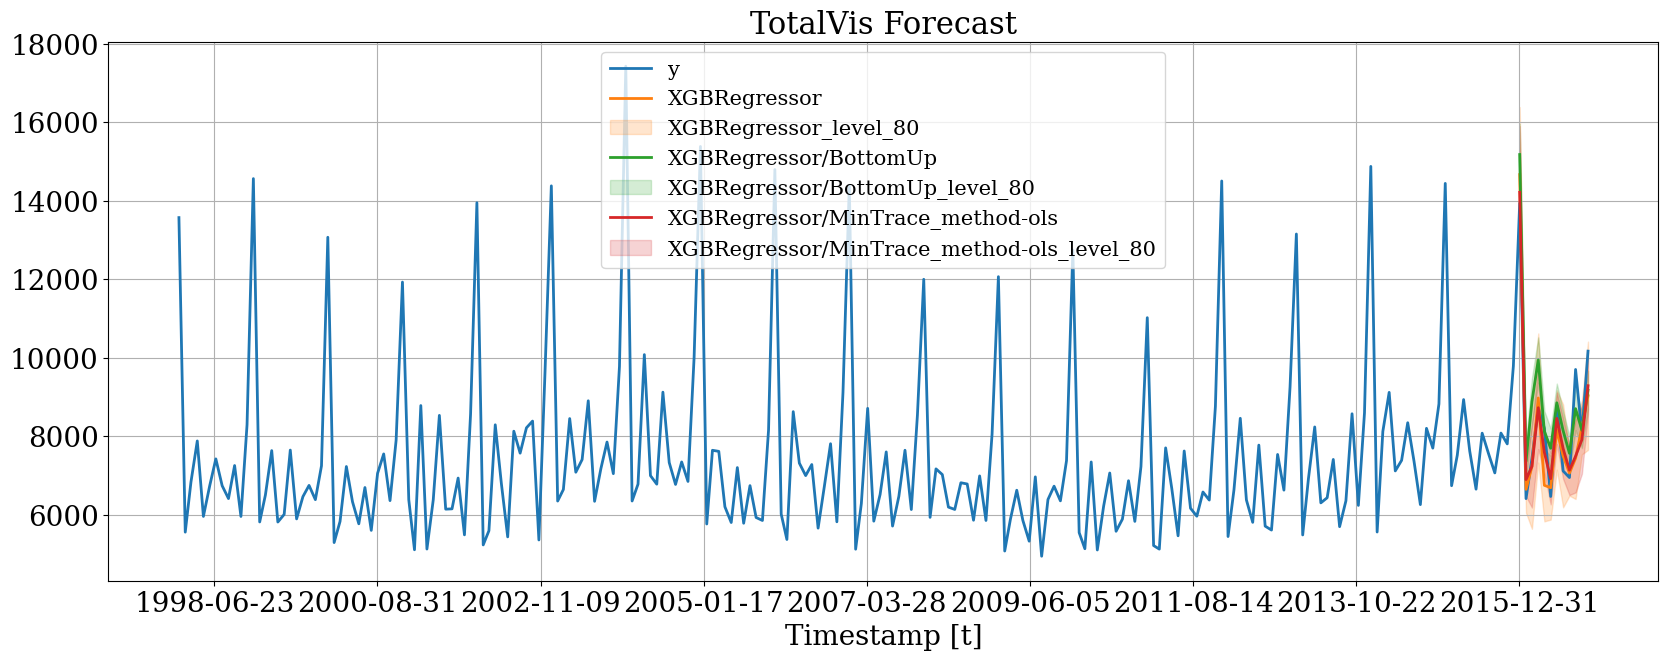

In [ ]:
hplot.plot_series(
    series='TotalVis',
    Y_df=plot_mf, 
    models=['y', 'XGBRegressor', 'XGBRegressor/BottomUp', 'XGBRegressor/MinTrace_method-ols'],
    level=[80]
)